In [1]:
import numpy as np
import pandas
import math
from scipy.optimize import curve_fit
from IPython.html.widgets import interact, fixed
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
%matplotlib inline
import seaborn as sns; sns.set()

from sklearn import linear_model
# fix random seed for reproducibility
np.random.seed(7)
import warnings
warnings.filterwarnings('ignore')

/Users/david/anaconda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using Theano backend.


In [2]:
dataframe = pandas.read_csv('/Users/david/notebooks/data/mmvoldata3.csv')

#dataframe["dprice"] = (dataframe["price"] - dataframe["price"].shift(1))
dataframe["dprice"] = (dataframe["price"] / dataframe["price"].shift(1))
dataframe["volshift"] = dataframe["volume"].shift(1)
dataframe["pricedir"] = dataframe["dprice"].apply(lambda x : 1 if x >1 else (0 if x == 1 else -1))
dataframe["mminventory"] = dataframe["pricedir"] * dataframe["volshift"]
dataframe["mmcumsum"] = dataframe["mminventory"].cumsum()
dataframe = dataframe.dropna()
dataframe.head()

,price,volume,dprice,volshift,pricedir,mminventory,mmcumsum
1,130.72,384,1.000000,1261.0,0,0.0,0.0
2,130.76,197,1.000306,384.0,1,384.0,384.0
3,130.75,408,0.999924,197.0,-1,-197.0,187.0
4,130.76,319,1.000076,408.0,1,408.0,595.0
5,130.78,354,1.000153,319.0,1,319.0,914.0


In [3]:
qdata = np.array(dataframe["volshift"])
mdata = np.array(dataframe["mmcumsum"])
pdata = np.array(dataframe["dprice"])
qdataln = np.log(qdata)
mdataln = np.log(mdata)
pdataln = np.log(pdata)

[-5.  -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3 -4.2 -4.1 -4.  -3.9 -3.8 -3.7 -3.6
 -3.5 -3.4 -3.3 -3.2 -3.1 -3.  -2.9 -2.8 -2.7 -2.6 -2.5 -2.4 -2.3 -2.2 -2.1
 -2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7 -0.6
 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4
  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9
  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5. ]


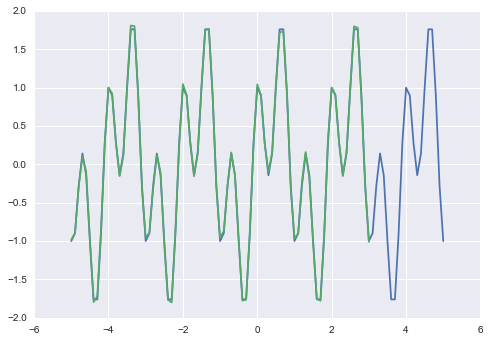

In [276]:
it = 101
#this for the sine curve
t = np.linspace(-5, 5, it)
#c1 = np.sin(np.pi*t) - np.sin(np.pi*(t+0.5))*0
c1 = np.sin(np.pi*(t+0.0)) - np.sin(np.pi*(t+0.5)*3)
c2 = c1 +(np.random.rand(it)-0.5)*0.1
#this for the gilt curve
#t = np.linspace(0, 500, 100)
#c1 = np.array(dataframe["price"])[0:500]
#c2 = c1+(np.random.rand(500)-0.5)*.1
#use the differences
if False :
    t = t[:-1]
    c1 = c1[:-1] - c1[1:]
    c2 = c2[:-1] - c2[1:]
plt.plot(t, c1)
plt.plot(t[:-20], c2[20:])
print(t)

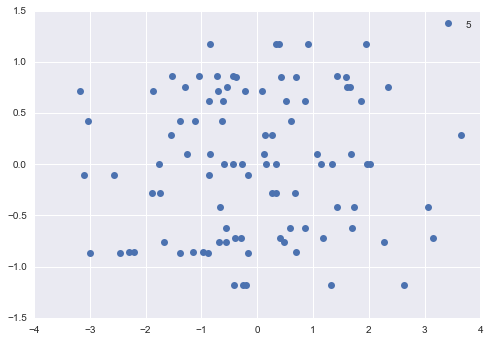

In [272]:
num = [5]
for n in num:
    plt.plot(c2[:-n], c1[n:], 'o', label = n)
plt.legend(loc='best')
#plt.plot(c1[:-num*2], c1[num*2:], 'o')

In [358]:
def reglag(lag):
    x1 = []
    #lagnum = 5
    #x1 = np.array([c1[i:i-lagnum] for i in range(1,lagnum, 5)])
    #y1 = c1[lagnum:]
    t1 = t[:-lag]
    x1 = np.array([c2[lag:]])
    y1 = c1[:-lag]
    y1 = y1.reshape(y1.shape[0], 1)
    #for i in range(1,20):
    #    x1.append(np.array(dataframe['price'].shift(i)))
    x1= np.transpose(x1)
    #print(np.shape(x1))
    #print(x1)
    #x2 = x1[:, lagnum:]
    #print(np.shape(x2))
    #print(np.shape(y1))

    clf = linear_model.LinearRegression()
    clf.fit(x1, y1)
    #print(clf.coef_)
    #print(t)
    #p = np.linspace(x1.min(), x1.max(), 100)
    p = np.sort(x1)
    predict = clf.predict(p.reshape(p.shape[0], 1))
    res = predict-y1
    clf2 = linear_model.LinearRegression()
    clf2.fit(p, res)
    respredict = clf2.predict(p.reshape(p.shape[0], 1))
    respredictsplit = np.array_split(respredict, 5)
    #constant variance
    var = [np.var(rps) for rps in respredictsplit]
    #zero mean
    mean = np.mean(respredict)
    #print(x1.reshape(1, x1.shape[0])[0])
    #print(res)
    x1r = x1.reshape(1, x1.shape[0])[0]
    resr = res.reshape(1, res.shape[0])[0]
    #no corr to x
    corr = np.corrcoef(x1r, resr)[0,1]
    #no autocorr
    acorr = [np.corrcoef(resr[:-i], resr[i:])[0,1] for i in range(1,10)]
    
    #print(predict.shape)
    #plt.figure(1)
    plt.subplot(221)
    plt.plot(x1, y1,'o')
    plt.plot(p, predict, '-')
    #plt.subplot(2,2)
    plt.subplot(222)
    plt.plot(p, res, 'o')
    plt.plot(p, respredict, '-')
    plt.subplot(223)
    plt.plot(t, c1, '-')
    plt.plot(t1, x1, '-')
    plt.subplot(224)
    #plt.plot(var, '-')
    plt.plot(resr[:-1],resr[1:], 'o')
    
    print('mean ', mean, 'corr ', corr, 'acorr ', acorr)
    
    score = clf.score(x1, y1)
    return clf.coef_[0][0], score, clf2.coef_[0][0]

In [91]:
def corrlag(lag):
    x1 = []
    x1 = np.array([c2[lag:]])
    y1 = c1[:-lag]
    #y1 = y1.reshape(y1.shape[0], 1)
    #print(x1.shape)
    #print(y1.shape)
    score = np.corrcoef(x1, y1)[0,1]
    return score

(101, 1)
(101, 8)
[ 0.12233705  0.          0.          0.          0.6725859   0.          0.
  0.        ]
[-0.00203047]


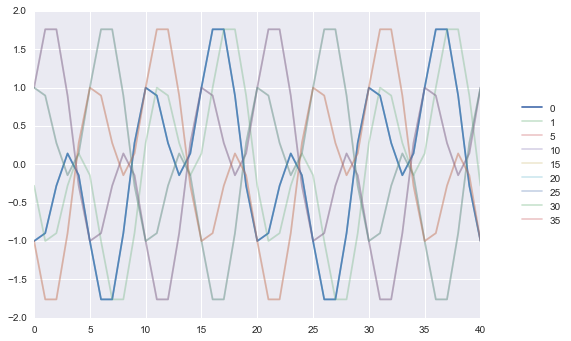

In [353]:
c3 = c1.reshape(c1.shape[0], 1)
you = [1, 5, 10, 15, 20, 25, 30, 35]
c4 = np.transpose([np.roll(c1,i) for i in you])
#c3 = c1.reshape(1, c1.shape[0])[0]
print(c3.shape)
print(np.shape(c4))
clf = linear_model.Lasso(alpha=0.2, positive=True)
#clf = linear_model.MultiTaskLasso(alpha=0.1)
clf.fit(c4, c3)
print(clf.coef_)
print(clf.intercept_)
plt.plot(c3[60:], label='0')
for i in you:
    plt.plot(np.roll(c1,i)[60:],label=i, alpha = 0.3)
plt.legend(loc='right',bbox_to_anchor=(1.2, 0.5),ncol=1)

mean  -4.60742555219e-17 corr  6.56216081812e-16 acorr  [0.65156423529317986, -0.11646126638129849, -0.70328580936446827, -0.63012431971732308, -0.00078554397771248778, 0.63159368897114754, 0.70959220135145273, 0.14798313757814791, -0.63615234279453581]


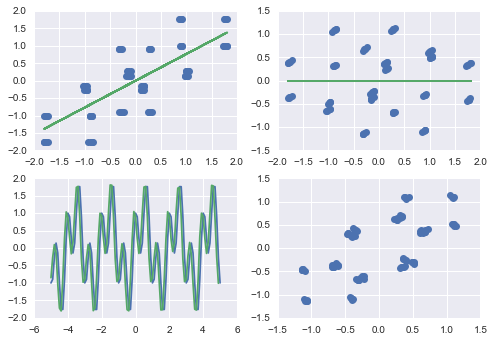

In [359]:
r = []
l = []
s = []
c = []
rcoef = []
start = 1
acorr = []
for i in range(start,start+1,1):
    a, b, d = reglag(i)
    r.append(a)
    l.append(t[-1]-t[-i-1])
    #print(t[-1])
    #print(t[-i-1])
    s.append(b)
    c.append(corrlag(i))
    rcoef.append(d)

In [285]:
import statsmodels.api as sm
data = sm.datasets.longley.load()
data.exog = sm.add_constant(data.exog)
ols_summary = sm.OLS(data.endog, data.exog).fit()
ols_resid = ols_summary.resid
res_fit = sm.OLS(ols_resid[1:], ols_resid[:-1]).fit()
rho = res_fit.params
print(ols_summary.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     330.3
Date:                Tue, 08 Nov 2016   Prob (F-statistic):           4.98e-10
Time:                        13:08:00   Log-Likelihood:                -109.62
No. Observations:                  16   AIC:                             233.2
Df Residuals:                       9   BIC:                             238.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -3.482e+06    8.9e+05     -3.911      0.0

In [280]:
from scipy.linalg import toeplitz
order = toeplitz(np.arange(16))
sigma = rho**order
gls_model = sm.GLS(data.endog, data.exog, sigma=sigma)
gls_results = gls_model.fit()
print(gls_results.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            GLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1886.
Date:                Tue, 08 Nov 2016   Prob (F-statistic):           2.01e-13
Time:                        13:06:45   Log-Likelihood:                -107.48
No. Observations:                  16   AIC:                             229.0
Df Residuals:                       9   BIC:                             234.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -3.8e+06   6.69e+05     -5.681      0.0

In [234]:
np.corrcoef(x1, res)

NameError: name 'x1' is not defined

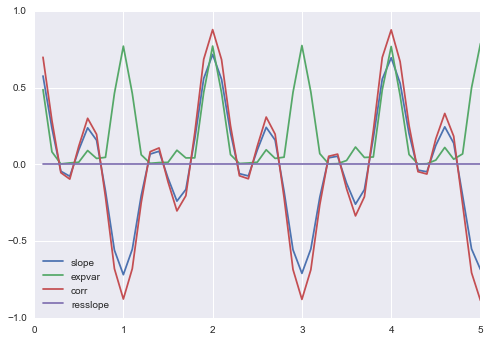

In [212]:
plt.plot(l, r, label ='slope')
plt.plot(l, s, label ='expvar')
plt.plot(l, c, label ='corr')
plt.plot(l, rcoef, label ='resslope')
plt.legend(loc='best')
#print(l)

In [ ]:
from mpl_toolkits import mplot3d

def plot_3D(x, y, z, elev=0, azim=-90):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(x, y, z, c=y, s=50, cmap='spring')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('q')
    ax.set_ylabel('m')
    ax.set_zlabel('p')

In [ ]:
#xdata = np.linspace(0, 4, 50)
#y = func(qdata, 1, , mdata)
#ydata = y + 0.2 * np.random.normal(size=len(xdata))

popt, pcov = curve_fit(func, (qdata, mdata), pdata)

#plot_3D(qdata, mdata, pdata)
interact(plot_3D, x=fixed(qdata), y=fixed(mdata), z=fixed(pdata), elev=[-90, 90], azip=(-180, 180));
print(popt)

In [ ]:
plt.plot(qdata, pdata, 'o')
poptlin, pcovlin = curve_fit(func2, (qdata, 0), pdata)
print(poptlin)
qfinelin = np.linspace(0.1, qdata.max(), fine)
curve = func2((qfinelin, 0), poptlin[0], poptlin[1])
plt.plot(qfinelin, curve, label='fit')

In [ ]:
qdataln = qdataln.reshape(qdataln.shape[0], 1)
qfinelinln = np.log(np.linspace(0.1, qdata.max(), fine))
ret =[]
def f1(x, y, start, end):
    x1 = x[start:end]
    y1 = y[start:end]
    plt.plot(x1, y1, 'o')
    clf = linear_model.LinearRegression()
    clf.fit(x1.reshape(x1.shape[0], 1), y1)
    predict = clf.predict(qfinelinln.reshape(qfinelinln.shape[0],1))
    plt.plot(qfinelinln, predict, '-', label=end)
    return clf.coef_[0]
    
for i in range(0, 500, 100):
    ret.append(f1(qdataln, pdataln, i,i+100))

plt.legend(loc='best')
print(ret)

In [ ]:
plt.plot(ret)

In [ ]:
fine = 50
qfine = np.linspace(0.000001, qdata.max(), fine)
#mfine = np.linspace(-mdata.max(), mdata.max(), 8)
mfine = np.linspace(0, mdata.max(), 8)
curve = func((qfine, 0), popt[0], popt[1], popt[2])
curve2 = func((qfine, mdata.max()), popt[0], popt[1], popt[2])
print(qfine)
print(curve)
for i in mfine:
    curvet = func((qfine, i), popt[0], popt[1], popt[2])
    plt.plot(qfine, curvet, label=i)
plt.legend(loc='best')
#plt.plot(xfine, curve2, 'b-')
#plt.plot(xdata, pdata)